In [1]:
import sys
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import numba
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..', '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
from QES.general_python.common.binary import get_global_logger
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import JAX_AVAILABLE, get_backend, get_global_logger, Array
from QES.general_python.common import Plotter, MatrixPrinter, colorsCycle, linestylesCycle
from QES.general_python.common import Directories
from QES.general_python.common import HDF5Handler
from QES.general_python.maths.statistics import HistogramAverage, Fraction

# ------------------------------------------------------------------
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.hilbert import HilbertSpace

# ------------------------------------------------------------------
from QES.Algebra.Properties import time_evo
from QES.Algebra.Properties import statistical
from QES.general_python.algebra.linalg import act, overlap, overlap_diag

# ------------------------------------------------------------------
import QES.Algebra.Operator.operators_spin as op_spin

logger      = get_global_logger()

# ------------------------------------------------------------------
data_dir = Directories(os.curdir, 'data')
data_dir.mkdir()

20_05_2025_01-03_20 [INFO] Log file created: ./log/QES_20_05_2025_01-03_20.log
20_05_2025_01-03_20 [INFO] Log level set to: info
20_05_2025_01-03_20 [INFO] ############Global logger initialized.############
20_05_2025_01-03_21 [INFO] JAX backend available and successfully imported
20_05_2025_01-03_21 [INFO] 	JAX 64-bit precision enabled.
20_05_2025_01-03_21 [INFO] Setting JAX as the active backend.
20_05_2025_01-03_21 [INFO] **************************************************
20_05_2025_01-03_21 [INFO] Backend Configuration:
20_05_2025_01-03_21 [INFO] 		NumPy Version: 2.1.3
20_05_2025_01-03_21 [INFO] 		SciPy Version: 1.15.2
20_05_2025_01-03_21 [INFO] 		JAX Version: 0.5.3
20_05_2025_01-03_21 [INFO] 		Active Backend: jax
20_05_2025_01-03_21 [INFO] 			JAX Available: True
20_05_2025_01-03_21 [INFO] 			Default Seed: 42
20_05_2025_01-03_21 [INFO] 		JAX Backend Details:
20_05_2025_01-03_21 [INFO] 				Main Module: jax.numpy
20_05_2025_01-03_21 [INFO] 				Random Module: jax.random (+ PRNGKey)
20

Directories(PosixPath('data'))

### Operator functions

In [2]:
sig_z_0 = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)
sig_z_c = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)
sig_z_l = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Local,
    sites   = [ns-1]
)

### Model test

20_05_2025_01-03_22 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
20_05_2025_01-03_22 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.252573 seconds.


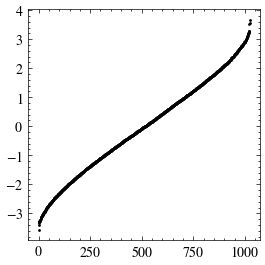

In [3]:
fig, ax = Plotter.get_subplots(1, 1, figsize=(3, 3))

model   = UltrametricModel(
    ns      = 10,
    n       = 3,
    alphas  = 0.8,
    backend = np
)

model.build()
model.diagonalize(verbose=True)

ax[0].plot(model.eig_val, 'o', ms = 1, color='black', label='Eigenvalues')

### Go through the model

In [4]:
@numba.njit(parallel=True, fastmath=True)
def f_function( start           : int,
                stop            : int,
                overlaps        : np.ndarray,
                eigvals         : np.ndarray,
                omegas_allocated: np.ndarray,
                vals_allocated  : np.ndarray,
                energy_target   : float = 0.0,
                bw              : float = 1.0,
                energy_diff_cut : float = 0.015):
    tol         = bw * energy_diff_cut
    n           = stop - start
    # worst-case pairs = n*(n-1)//2
    max_pairs   = n*(n-1)//2
    omegas      = omegas_allocated
    vals        = vals_allocated
    cnt         = 0
    nh          = len(eigvals)
    for ii in numba.prange(start, stop):
        en_i = eigvals[ii]
        for jj in range(ii+1, nh):
            # inline is_close_target:
            if abs((en_i + eigvals[jj])*0.5 - energy_target) >= tol:
                continue

            # compute and store
            omega       = abs(en_i - eigvals[jj])
            m2          = abs(overlaps[ii, jj])**2
            omegas[cnt] = omega
            vals[cnt]   = m2
            cnt        += 1
            
    return omegas[:cnt], vals[:cnt]

20_05_2025_01-06_00 [INFO] Number of realisations: {np.int64(6): 5, np.int64(7): 5, np.int64(8): 5, np.int64(9): 5, np.int64(10): 5}
20_05_2025_01-06_00 [INFO] Number of sites: 5
20_05_2025_01-06_00 [INFO] Alphas: [0.8 0.9]
20_05_2025_01-06_00 [INFO] Sites: [ 6  7  8  9 10]
20_05_2025_01-06_00 [INFO] 	->ns = 6
20_05_2025_01-06_00 [INFO] 		->[HilbertSpace] Inferred Ns=6 from Nh=64 and Nhl=2
20_05_2025_01-06_00 [INFO] 		->[HilbertSpace] Inferred Ns=6 from Nh=64 and Nhl=2
20_05_2025_01-06_00 [INFO] 		->ns = 6, alpha = 0.80
20_05_2025_01-06_00 [INFO] 			->ns = 6, alpha = 0.80, r = 0
20_05_2025_01-06_00 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
20_05_2025_01-06_00 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.001303 seconds.
20_05_2025_01-06_00 [INFO] 			->ns = 6, alpha = 0.80, r = 1
20_05_2025_01-06_00 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
20_05_2025_01-06_00 [INFO] 		->[Hamiltonian] Diagonalization (standard) com

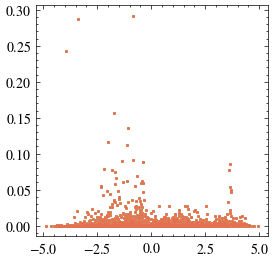

In [9]:
alphas = np.arange(0.8, 1.0, 0.1)
sites  = np.arange(6, 11, dtype=int)
n_realisations = {ns: 5 for ns in sites}
# n_realisations = {ns: 10 * (np.max(sites) - np.min(sites)) - 10 * (ns - np.min(sites)) + 1 for ns in sites}

logger.info(f"Number of realisations: {n_realisations}")
logger.info(f"Number of sites: {len(sites)}")
logger.info(f"Alphas: {alphas}")
logger.info(f"Sites: {sites}")

fig, ax = Plotter.get_subplots(1, 1, figsize=(3, 3))

#! -------------------------------------------------------

operators_map = {
    'sig_z_0': sig_z_0,
    'sig_z_c': sig_z_c,
}

#! -------------------------------------------------------
# prepare the 3-level containers:
#   histograms_av[op][alpha][ns] → HistogramAverage
histograms_av  = {
    op: {alpha: {} for alpha in alphas}
    for op in operators_map
}
histograms_typ = {
    op: {alpha: {} for alpha in alphas}
    for op in operators_map
}
bandwidths    = {
    alpha: [] for alpha in alphas
}

#! -------------------------------------------------------

for ins, ns in enumerate(sites):
    logger.info(f"ns = {ns}", lvl=1, color='blue')
    
    hilbert_size        = 2**ns
    operators           = {k: v(ns) for k, v in operators_map.items()}
    op_mats             = {k: op.matrix(dim=hilbert_size) for k, op in operators.items()}
    max_allocated       = hilbert_size * (hilbert_size - 1) // 2
    omegas_allocated    = np.zeros(max_allocated, dtype=np.float64)
    vals_allocated      = np.zeros(max_allocated, dtype=np.float64)
    
    #! pre-allocate the values to save
    n_realisations_in   = n_realisations[ns]
    ldos                = np.zeros(shape=(n_realisations_in, hilbert_size), dtype=np.float64)
    time_num            = 1000
    time_vals           = { k : np.zeros(shape=(n_realisations_in, time_num), dtype=np.float64) for k, _ in operators_map.items() }
    quench_state        = np.zeros(shape=(hilbert_size,), dtype=np.float64)
    overlaps            = np.zeros(shape=(hilbert_size,), dtype=np.float64)
    idx                 = 0
    for alpha in alphas:
        logger.info(f"ns = {ns}, alpha = {alpha:.2f}", lvl=2, color='green')

        # placeholders for this (ns,alpha)
        bandwidth = None
        h_av      = {}
        h_typ     = {}

        for r in range(n_realisations_in):
            logger.info(f"ns = {ns}, alpha = {alpha:.2f}, r = {r}", lvl=3, color='red')
            
            #! build & diag
            model = UltrametricModel(
                ns      = ns,
                n       = 1,
                alphas  = alpha,
                backend = np
            )
            model.build()
            model.diagonalize(verbose=True)
            mean_energy     = model.av_en
            bandwidth       = model.get_bandwidth()
            bandwidths[alpha].append(bandwidth)
            
            #! select the quench state
            if True:
                quench_state[idx]   = 0.0
                diff                = np.abs(model.eig_val - mean_energy)
                idx                 = int(np.argmin(diff))
                quench_state[idx]   = 1.0
                overlaps            = model.eig_vec.T @ quench_state
                
            #! compute the ldos
            if True:
                ldos[r, :] = statistical.ldos(energies = model.eig_val, overlaps = overlaps)
                ax[0].plot(model.eig_val, ldos[r, :], 'o', ms = 1, label='LDOS')
                
            #! on first realisation, init histograms
            if bandwidth is None or r == 0:
                o_max     = 3 * bandwidth
                o_min     = 0.1 / model.hilbert_size
                n_bins    = int(20 * np.log2(model.hilbert_size))
                edges     = HistogramAverage.uniform_log(n_bins, v_max=o_max, v_min=o_min)
                for name in operators:
                    h_av[name]  = HistogramAverage(n_bins, edges=edges)
                    h_typ[name] = HistogramAverage(n_bins, edges=edges)
            
            #! accumulate into the single histogram
            for name in operators:
                
                overlaps = overlap(model.eig_vec, op_mats[name])
                
                omegas, vals = f_function(
                    start               = 0,
                    stop                = len(model.eig_vec),
                    overlaps            = overlaps,
                    eigvals             = model.eig_val,
                    omegas_allocated    = omegas_allocated,
                    vals_allocated      = vals_allocated,
                    energy_target       = 0.0,
                    bw                  = bandwidth
                )
                #! remove zeros and nan
                mask    = np.logical_and(vals > 0, np.isfinite(vals))
                omegas  = omegas[mask]
                vals    = vals[mask]
                h_av[name].append(omegas, vals)
                h_typ[name].append(omegas, np.log(vals))
                
                #! time evolution
                

        #! store the combined histogram for this (ns,alpha)
        for name in operators:
            histograms_av[name][alpha][ns] = h_av[name]
            histograms_typ[name][alpha][ns] = h_typ[name]
            # histograms_typ[k][alpha].append(histogram_typ)


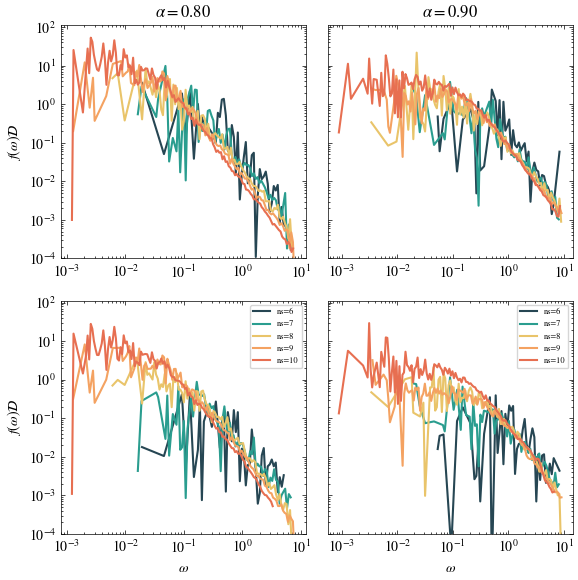

In [10]:
fig, ax = Plotter.get_subplots(
    nrows    = len(operators_map),
    ncols    = len(alphas),
    figsize  = (3*len(alphas), 3*len(operators_map)),
    sharey   = True
)

typical = False

for op_idx, (op_name, _) in enumerate(operators_map.items()):
    for alpha_idx, alpha in enumerate(alphas):
        idx_ax  = op_idx * len(alphas) + alpha_idx
        axis    = ax[idx_ax]

        #! plot each ns into the same histogram
        for ns in sites:
            h       = (histograms_typ if typical else histograms_av)[op_name][alpha][ns]
            vals    = h.averages_av(is_typical=typical) * 2**ns

            # one mask for >0, finite
            mask    = (vals > 0) & np.isfinite(vals)
            if not mask.any():
                continue

            axis.plot(h.bin_edges[mask], vals[mask], label=f"ns={ns}", lw=1.5)

        # log–log and fixed y-range
        axis.set_xscale('log')
        axis.set_yscale('log')
        axis.set_ylim(1e-4, None)

        # only bottom row gets the x-label
        if op_idx == len(operators_map) - 1:
            axis.set_xlabel(r'$\omega$')

        # only first column gets the y-label
        if alpha_idx == 0:
            axis.set_ylabel(r'$f(\omega) \mathcal{D}$')

        # legend in bottom of each column (or top-right of bottom row)
        if op_idx == len(operators_map) - 1:
            axis.legend(frameon=True, loc='upper right', fontsize=6)

        # optional: put alpha in the column title on top row
        if op_idx == 0:
            axis.set_title(f"$\\alpha = {alpha:.2f}$")

fig.tight_layout()
